### Optimizing Dataframe Memory Footprint
https://app.dataquest.io/m/163/optimizing-dataframe-memory-footprint/14/converting-to-categorical-to-save-memory

In [106]:
# BlockManager class is responsible for maintaining the mapping between the row and column indexes and the actual blocks
# retrieve the internal BlockManager object from within a dataframe using the DataFrame._data private attribute
import pandas as pd
moma = pd.read_csv("moma.csv")
print(moma._data)

BlockManager
Items: Index(['ExhibitionID', 'ExhibitionNumber', 'ExhibitionTitle',
       'ExhibitionCitationDate', 'ExhibitionBeginDate', 'ExhibitionEndDate',
       'ExhibitionSortOrder', 'ExhibitionURL', 'ExhibitionRole',
       'ConstituentID', 'ConstituentType', 'DisplayName', 'AlphaSort',
       'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution',
       'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate',
       'ArtistBio', 'Gender', 'VIAFID', 'WikidataID', 'ULANID',
       'ConstituentURL'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=34558, step=1)
FloatBlock: [0, 6, 9, 19, 20, 23, 25], 7 x 34558, dtype: float64
ObjectBlock: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 26], 20 x 34558, dtype: object


In [107]:
# retrieve the amount of memory the values in a column consume using the Series.nbytes attribute
# a kilobyte is equivalent to 1,024 bytes (2^10), and a megabyte is equivalent to 1,048,576 bytes (2^20)
total_bytes = moma.size*8
total_megabytes = total_bytes/1048576
print(total_bytes, total_megabytes)

7464528 7.1187286376953125


In [108]:
obj_cols = moma.select_dtypes(include=['object'])
obj_cols_mem = obj_cols.memory_usage(deep=True)
print(obj_cols_mem)
obj_cols_sum = obj_cols_mem.sum()/1048576
print(obj_cols_sum)

Index                          80
ExhibitionNumber          2085250
ExhibitionTitle           3333695
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104909
MiddleName                1218917
LastName                  2162937
Suffix                    1110333
Institution               1221368
Nationality               1949664
ArtistBio                 3183300
Gender                    1858994
WikidataID                1821293
ConstituentURL            2677922
dtype: int64
43.766947746276855


object 	bool 	    float 	    int 	datetime
object 	bool 	    float16 	int8 	datetime64
		            float32 	int16 	
		            float64 	int32 	
		            float128 	int64 	

In [109]:
import numpy as np
int_type =["int8", "int16","int32","int64"]
print("int8:", np.iinfo("int8").min, np.iinfo("int8").max)
print("int16:",np.iinfo("int16").min, np.iinfo("int16").max)
print("int32:",np.iinfo("int32").min, np.iinfo("int32").max)
print("int64:",np.iinfo("int64").min, np.iinfo("int64").max)

int8: -128 127
int16: -32768 32767
int32: -2147483648 2147483647
int64: -9223372036854775808 9223372036854775807


In [110]:
import numpy as np
col_max = moma['ExhibitionSortOrder'].max()
col_min = moma['ExhibitionSortOrder'].min()

if col_max <  np.iinfo("int8").max and col_min > np.iinfo("int8").min:
    moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype("int8")
elif col_max <  np.iinfo("int16").max and col_min > np.iinfo("int16").min:
    moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype("int16")
elif col_max <  np.iinfo("int32").max and col_min > np.iinfo("int32").min:
    moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype("int32")
elif col_max <  np.iinfo("int64").max and col_min > np.iinfo("int64").min:
    moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype("int64")
print(moma['ExhibitionSortOrder'].dtype)
print(moma['ExhibitionSortOrder'].memory_usage(deep=True))

int16
69196


In [111]:
value_bytes = len(moma) * 2 + 80 # index memory
print(value_bytes == moma['ExhibitionSortOrder'].memory_usage(deep=True))

True


In [113]:
# Series.astype() use float64 by default
# use the downcast parameter in pandas.to_numeric() function to have pandas to find the optimal subtype
moma = pd.read_csv("moma.csv")
moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype("int16")
float_cols = moma.select_dtypes(include=['float'])
print(float_cols.dtypes)
for col in float_cols.columns:
    moma[col] = pd.to_numeric(moma[col], downcast='float')
print(moma.select_dtypes(include=['float']).dtypes)

ExhibitionID            float64
ConstituentID           float64
ConstituentBeginDate    float64
ConstituentEndDate      float64
VIAFID                  float64
ULANID                  float64
dtype: object
Series([], dtype: object)


In [114]:
moma['ExhibitionBeginDate'] = pd.to_datetime(moma['ExhibitionBeginDate'])
moma['ExhibitionEndDate'] = pd.to_datetime(moma['ExhibitionEndDate'])
a = moma['ExhibitionBeginDate'].memory_usage(deep=True)
b = moma['ExhibitionEndDate'].memory_usage(deep=True)
print(a, b)

276544 276544


In [115]:
# use Series.cat.codes attribute to return the integer values of the category type 
# The category subtype handle missing values by setting them to -1
# use the category type primarily for object columns where less than 50% of the values are unique
obj_cols = moma.select_dtypes(include=['object'])
for col in obj_cols.columns:
    num_unique_values = len(moma[col].unique())
    num_total_values = len(moma[col])
    if num_unique_values / num_total_values < 0.5:
        moma[col] = moma[col].astype('category')
        
print(moma.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
ExhibitionID              34129 non-null float32
ExhibitionNumber          34558 non-null category
ExhibitionTitle           34558 non-null category
ExhibitionCitationDate    34557 non-null category
ExhibitionBeginDate       34558 non-null datetime64[ns]
ExhibitionEndDate         33354 non-null datetime64[ns]
ExhibitionSortOrder       34558 non-null int16
ExhibitionURL             34125 non-null category
ExhibitionRole            34424 non-null category
ConstituentID             34044 non-null float32
ConstituentType           34424 non-null category
DisplayName               34424 non-null category
AlphaSort                 34424 non-null category
FirstName                 31499 non-null category
MiddleName                3804 non-null category
LastName                  31998 non-null category
Suffix                    157 non-null category
Institution               2458 non-nu

In [240]:
# specify the optimal column types when read in the data set
keep_cols = ['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 'ExhibitionEndDate', 'ExhibitionSortOrder', 'ExhibitionRole', 'ConstituentType', 'DisplayName', 'Institution', 'Nationality', 'Gender']
moma = pd.read_csv("moma.csv", parse_dates=["ExhibitionBeginDate", "ExhibitionEndDate"], usecols=keep_cols)
print(moma.memory_usage(deep=True).sum()/(1024*1024))

14.555106163024902


### Processing Dataframes in Chunks
https://app.dataquest.io/m/164/processing-dataframes-in-chunks

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 94., 37.]),
 array([0.07383919, 0.1022049 , 0.1305706 , 0.15893631, 0.18730202,
        0.21566772, 0.24403343, 0.27239914, 0.30076485, 0.32913055,
        0.35749626]),
 <a list of 10 Patch objects>)

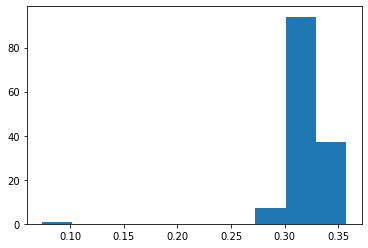

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

memory_footprints = []
chunk_iter = pd.read_csv('moma.csv', chunksize=250)
for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))
plt.hist(memory_footprints)

In [119]:
num_rows = 0
chunk_iter=pd.read_csv('moma.csv', chunksize=250)
for chunk in chunk_iter:
    num_rows += len(chunk)
print(num_rows)

34558


In [120]:
dtypes = {"ConstituentBeginDate": "float", "ConstituentEndDate": "float"}
chunk_iter = pd.read_csv('moma.csv', chunksize=250, dtype=dtypes)
lifespans = []
for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)
lifespans_dist = pd.concat(lifespans)
print(lifespans_dist.head(10))

0    79.0
1    67.0
2    55.0
3    37.0
4    32.0
5    74.0
6    52.0
7    41.0
8    85.0
9    65.0
dtype: float64


In [41]:
%%timeit
lifespans = []
chunk_iter = pd.read_csv('Raw_data\moma.csv', chunksize=250, dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"})
for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])
lifespans_dist = pd.concat(lifespans)

1.27 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
%%timeit
lifespans = []
chunk_iter = pd.read_csv('moma.csv', chunksize=250, dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"},  usecols=['ConstituentBeginDate', 'ConstituentEndDate'])
for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])
lifespans_dist = pd.concat(lifespans)

839 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
overall_vc = []
chunk_iter = pd.read_csv('moma.csv', chunksize=250, usecols=['Gender'])
for chunk in chunk_iter:
    overall_vc.append(chunk['Gender'].value_counts())
combined_vc=pd.concat(overall_vc)
combined_vc.head(10)

Male      208
Female      9
Male      193
Female      6
Male      195
Female      8
Male      104
Female      6
Male      103
Female     10
Name: Gender, dtype: int64

In [123]:
chunk_iter = pd.read_csv('moma.csv', chunksize=250, usecols=['Gender'])
overall_vc=[]
for chunk in chunk_iter:
    overall_vc.append(chunk['Gender'].value_counts())
combined_vc=pd.concat(overall_vc)
final_vc=combined_vc.groupby(combined_vc.index).sum()
final_vc

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

In [124]:
chunk_iter = pd.read_csv('moma.csv', chunksize=1000)
df_list = []
# group each unique value in the Gender column by each unique value in the ExhibitionID column
for chunk in chunk_iter:
    temp = chunk['Gender'].groupby(chunk['ExhibitionID']).value_counts()
    df_list.append(temp)
final_df = pd.concat(df_list)

#Use the GroupBy method again to sum the gender counts for each unique index value
id_gender_counts = final_df.groupby(final_df.index).sum()
id_gender_counts.head(10)

(2.0, Male)       1
(5.0, Male)       3
(6.0, Female)     2
(6.0, Male)      32
(7.0, Male)      69
(9.0, Male)       4
(10.0, Male)      2
(15.0, Male)      1
(17.0, Male)      4
(19.0, Male)      2
Name: Gender, dtype: int64

## Improving CPU performance
https://app.dataquest.io/m/168/cpu-bound-programs/3/the-dataset

In [125]:
import pandas as pd

data = pd.read_csv("ecommerce5000.csv", encoding="Latin-1")
data.head(2)

,Unnamed: 0,_unit_id,relevance,relevance:variance,product_image,product_link,product_price,product_title,query,rank,source,url
0,0,711158459,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$329.98,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,playstation 4,1,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...
1,1,711158460,4.00,0.000,http://thumbs3.ebaystatic.com/d/l225/m/mJNDmSy...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$324.84,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,2,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...


In [126]:
data.shape

(5000, 12)

In [127]:
iz_operations = 0      # Count how many times the i == z check is performed
item_operations = 0    # Count how many times the item == item2 check is performed
duplicates_init = 0    # Count how many times the duplicates = [] operation is performed.
duplicates_false = 0   # Count how many times the duplicates = False operation is performed.
duplicates_true = 0    # Count how many times the duplicates = True operation is performed.
if_duplicate = 0       # Count how many times the if duplicate operation is performed.
duplicates_append = 0  # Count how many times the duplicates.append(duplicate) operation is performed

duplicates_init += 1
duplicates = []
query = data['query']

# Loop through each item in the query column.
for i, item in enumerate(query):
    duplicates_false += 1
    duplicate = False
    
    # Loop through each item in the query column.
    for z, item2 in enumerate(query):
        # If the outer and inner loops are on the same value, keep going.
        # Without this, we'll falsely detect rows as duplicates.
        iz_operations += 1
        if i == z:
            continue
        # Mark as duplicate if we find a match.
        item_operations += 1
        if item == item2:
            duplicates_true += 1
            duplicate = True
    if_duplicate += 1
    # Add to the duplicates list.
    if duplicate:
        duplicates_append += 1
        duplicates.append(item)
print(iz_operations)
print(item_operations)
print(duplicates_init)
print(duplicates_false)
print(duplicates_true)
print(if_duplicate)
print(duplicates_true)

25000000
24995000
1
5000
164774
5000
164774


In [10]:
total = 0
sum_increments = 0
for item in query:
    sum_increments += 1
    total += len(item)
print(total, sum_increments)

75328 5000


big O notations:
    O(n^2): two for loops
    O(1): no loop  # print(query[0])    

In [11]:
counts_increments = 0
value_checks = 0
counts = {}
for item in query:
    if item not in counts:
        counts[item] = 0
    counts_increments += 1
    counts[item] += 1

duplicates = []
for key, val in counts.items():
    value_checks += 1
    if val > 1:
        duplicates.append(key)

print(counts_increments)
print(value_checks)

5000
170


In [12]:
import time
query_series = data['query']
start = time.time()
duplicate_series = query_series.duplicated()
duplicate_values_series = query_series[duplicate_series]
pandas_elapsed = time.time() - start
print(pandas_elapsed)

start = time.time()
counts = {}
for item in query:
    if item not in counts:
        counts[item] = 0
    counts[item] += 1

duplicates = []
for key, val in counts.items():
    if val > 1:
        duplicates.append(key)
elapsed = time.time() - start
print(elapsed)

0.0
0.01565241813659668


0.0
0.0


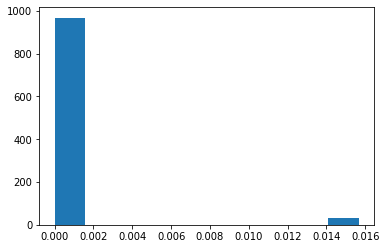

(array([931.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  69.]),
 array([0.        , 0.0015662 , 0.00313239, 0.00469859, 0.00626478,
        0.00783098, 0.00939717, 0.01096337, 0.01252956, 0.01409576,
        0.01566195]),
 <a list of 10 Patch objects>)

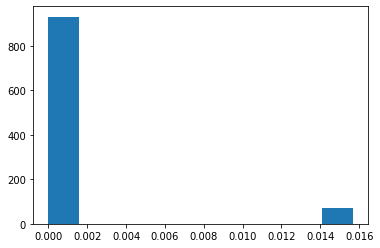

In [13]:
import time
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

def pandas_algo():
    duplicate_series = query_series.duplicated()
    duplicate_values_series = query_series[duplicate_series]
    
def algo():
    counts = {}
    for item in query:
        if item not in counts:
            counts[item] = 0
        counts[item] += 1

    duplicates = []
    for key, val in counts.items():
        if val > 1:
            duplicates.append(key)
        
pandas_elapsed = []
for i in range(1000):
    start = time.time()
    pandas_algo()
    pandas_elapsed.append(time.time() - start)

elapsed = []
for i in range(1000):
    start = time.time()
    algo()
    elapsed.append(time.time() - start)

print(statistics.median(pandas_elapsed))
print(statistics.median(elapsed))

plt.hist(pandas_elapsed)
plt.show()
plt.hist(elapsed)

In [16]:
import time
import statistics
def algo():
    unique = set()
    duplicates = set()
    for item in query:
        if item in unique:
            duplicates.add(item)
        else:
            unique.add(item)

elapsed = []
for i in range(1000):
    start = time.time()
    algo()
    elapsed.append(time.time() - start)

print(statistics.median(elapsed))

0.0


In [15]:
import cProfile
cProfile.run('print(10)')

10
         38 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 iostream.py:195(schedule)
        2    0.000    0.000    0.000    0.000 iostream.py:307(_is_master_process)
        2    0.000    0.000    0.000    0.000 iostream.py:320(_schedule_flush)
        2    0.000    0.000    0.000    0.000 iostream.py:382(write)
        3    0.000    0.000    0.000    0.000 iostream.py:93(_event_pipe)
        3    0.000    0.000    0.000    0.000 socket.py:337(send)
        3    0.000    0.000    0.000    0.000 threading.py:1038(_wait_for_tstate_lock)
        3    0.000    0.000    0.000    0.000 threading.py:1080(is_alive)
        3    0.000    0.000    0.000    0.000 threading.py:507(is_set)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        2    0.000    0.000    

In [41]:
def algo():
    unique = set()
    duplicates = set()
    for item in query:
        if item in unique:
            duplicates.add(item)
        else:
            unique.add(item)
cProfile.run('algo()')

         5064 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <ipython-input-41-0c70ec772080>:1(algo)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 base.py:1117(__iter__)
        1    0.000    0.000    0.000    0.000 base.py:75(is_dtype)
        4    0.000    0.000    0.000    0.000 blocks.py:165(internal_values)
        2    0.000    0.000    0.000    0.000 common.py:117(classes)
        2    0.000    0.000    0.000    0.000 common.py:119(<lambda>)
        1    0.000    0.000    0.000    0.000 common.py:1702(is_extension_array_dtype)
        2    0.000    0.000    0.000    0.000 common.py:1845(_is_dtype_type)
        2    0.000    0.000    0.000    0.000 common.py:1981(pandas_dtype)
        1    0.000    0.000    0.000    0.000 common.py:403(is_datetime64_dtype)
        1    0.000    0.00

In [ ]:
from contexttimer import Timer
with Timer() as t:
    algo()
print(t.elapsed)

In [61]:
# Splits the data into groups based on query.  Fnds the product_link with the highest relevance for each group
import time 
import statistics

def run_with_timing(func):
    elapsed = []
    for i in range(10):
        start = time.time()
        func()
        elapsed.append(time.time() - start)
    return statistics.median(elapsed)

def pandas_algo():
    get_max_relevance = lambda x: x.loc[x["relevance"].idxmax(), "product_link"]
    return data.groupby("query").apply(get_max_relevance)

def pandas_algo1():
    group = data.groupby('query')
    hr = data['relevance'].sort_values(ascending=False)
    pl = data.iloc[hr.index]['product_link']
    return pl

relevance = list(data['relevance'])
product_link = list(data['product_link'])

def algo():
    links = {}
    for i, row in enumerate(query):
        if row not in links:
            links[row] = [0,""]
        if relevance[i] > links[row][0]:
            links[row] = [relevance[i], product_link[i]]
    return links

pandas_elapsed = run_with_timing(pandas_algo)
p_elapsed = run_with_timing(pandas_algo1)
elapsed = run_with_timing(algo)
print('pandas_elapsed=', pandas_elapsed, 'p_elapsed=', p_elapsed, 'elapsed=', elapsed)

pandas_elapsed= 0.031227588653564453 p_elapsed= 0.0 elapsed= 0.0


In [ ]:
# space complexity
import re
import statistics

def algo1(data):
    total = 0
    for index, row in data.iterrows():
        total += int(row["rank"])
    return total

def algo2(data):
    prices = []
    for index, row in data.iterrows():
        price_search = re.search('.*(\d+).*', row["product_price"], re.IGNORECASE)

        if price_search:
            price = float(price_search.group(1))
        else:
            price = None
        prices.append(price)
    price_avg = statistics.mean([p for p in prices if p is not None])
    weighted_relevance = []
    for index, row in data.iterrows():
        if prices[index] is not None:
            price = prices[index] / price_avg
        else:
            price = price_avg
        weighted_relevance.append(float(row["relevance"]) * price)
    return weighted_relevance

algo1_time_complexity = 1
algo1_space_complexity = 0

algo2_time_complexity = 1
algo2_space_complexity = 1

### improve the performance of I/O bound tasks
https://app.dataquest.io/m/169/i%2Fo-bound-programs

In [32]:
import cProfile
import sqlite3

query = "SELECT DISTINCT teamID from Teams inner join TeamsFranchises on Teams.franchID == TeamsFranchises.franchID where TeamsFranchises.active = 'Y';"
conn = sqlite3.connect("Raw_data\lahman2015.sqlite")
cur = conn.cursor()
teams = [row[0] for row in cur.execute(query).fetchall()]
print(teams)

['BSN', 'CHN', 'CN2', 'PT1', 'SL4', 'NY1', 'PHI', 'BR3', 'PIT', 'BRO', 'CIN', 'SLN', 'BLA', 'BOS', 'CHA', 'CLE', 'DET', 'MLA', 'PHA', 'WS1', 'SLA', 'NYA', 'ML1', 'BAL', 'KC1', 'LAN', 'SFN', 'LAA', 'MIN', 'WS2', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK', 'KCA', 'SE1', 'MON', 'SDN', 'ML4', 'TEX', 'SEA', 'TOR', 'COL', 'FLO', 'ANA', 'TBA', 'ARI', 'MIL', 'WAS', 'MIA']


In [33]:
cur.execute("select name from sqlite_master where type = 'table';")
cur.fetchall()

[('AllstarFull',),
 ('Appearances',),
 ('AwardsManagers',),
 ('AwardsPlayers',),
 ('AwardsShareManagers',),
 ('AwardsSharePlayers',),
 ('Batting',),
 ('BattingPost',),
 ('CollegePlaying',),
 ('Fielding',),
 ('FieldingOF',),
 ('FieldingPost',),
 ('HallOfFame',),
 ('Managers',),
 ('ManagersHalf',),
 ('Master',),
 ('Pitching',),
 ('PitchingPost',),
 ('Salaries',),
 ('Schools',),
 ('SeriesPost',),
 ('Teams',),
 ('TeamsFranchises',),
 ('TeamsHalf',)]

In [34]:
import cProfile
import sqlite3

teams = [row[0] for row in cur.execute(query).fetchall()]
query = "SELECT SUM(HR) FROM Batting WHERE teamId=?"
def calculate_runs(teams):
    home_runs = []
    for team in teams:
        runs = cur.execute(query, [team]).fetchall()
        runs = runs[0][0]
        home_runs.append(runs)
    return home_runs

profile_string = "home_runs = calculate_runs(teams)"
cProfile.run(profile_string)

         157 function calls in 0.342 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.342    0.342 <ipython-input-34-43d63a2da8a0>:6(calculate_runs)
        1    0.000    0.000    0.342    0.342 <string>:1(<module>)
        1    0.000    0.000    0.342    0.342 {built-in method builtins.exec}
       51    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
       51    0.341    0.007    0.341    0.007 {method 'execute' of 'sqlite3.Cursor' objects}
       51    0.000    0.000    0.000    0.000 {method 'fetchall' of 'sqlite3.Cursor' objects}




In [40]:
import sqlite3

memory = sqlite3.connect(':memory:') # create a memory database
disk = sqlite3.connect('Raw_data\lahman2015.sqlite')

dump = "".join([line for line in disk.iterdump() if "Batting" in line])
memory.executescript(dump)

cur = memory.cursor()
query = "SELECT SUM(HR) FROM Batting WHERE teamId=?"
def calculate_runs(teams):
    home_runs = []
    for team in teams:
        runs = cur.execute(query, [team]).fetchall()
        runs = runs[0][0]
        home_runs.append(runs)
    return home_runs

profile_string = "home_runs = calculate_runs(teams)"
cProfile.run(profile_string)

         157 function calls in 0.055 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.055    0.055 <ipython-input-40-4b79ac3a6385>:11(calculate_runs)
        1    0.000    0.000    0.055    0.055 <string>:1(<module>)
        1    0.000    0.000    0.055    0.055 {built-in method builtins.exec}
       51    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
       51    0.055    0.001    0.055    0.001 {method 'execute' of 'sqlite3.Cursor' objects}
       51    0.000    0.000    0.000    0.000 {method 'fetchall' of 'sqlite3.Cursor' objects}




In [46]:
import threading

def task(team):
    print(team)
    
for i, team in enumerate(teams):
    thread = threading.Thread(target=task, args=(team,))
    thread.start()
    print("Started task {}".format(i))
print(teams)

BSN
Started task 0
CHNStarted task 1

CN2Started task 2

PT1
Started task 3
SL4
Started task 4
NY1Started task 5

PHIStarted task 6

BR3
Started task 7
PIT
Started task 8
BROStarted task 9

CINStarted task 10

SLN
Started task 11
BLA
Started task 12
BOS
Started task 13
CHAStarted task 14

CLE
Started task 15
DET
Started task 16
MLAStarted task 17

PHA
Started task 18
WS1
Started task 19
SLA
Started task 20
NYAStarted task 21

ML1
Started task 22
BAL
Started task 23
KC1
Started task 24
LAN
Started task 25
SFN
Started task 26
LAA
Started task 27
MIN
Started task 28
WS2Started task 29

HOU
Started task 30
NYN
Started task 31
CALStarted task 32

ATL
Started task 33
OAKStarted task 34

KCA
Started task 35
SE1Started task 36

MON
Started task 37
SDNStarted task 38

ML4
Started task 39
TEXStarted task 40

SEA
Started task 41
TORStarted task 42

COL
Started task 43
FLOStarted task 44

ANA
Started task 45
TBAStarted task 46

ARIStarted task 47

MIL
Started task 48
WAS
Started task 49
MIAStarted

In [48]:
import threading
import time

def task(team):
    time.sleep(3)
    print(team)

for i, team in enumerate(teams):
    thread = threading.Thread(target=task, args=(team,))
    thread.start()
    print("Started task {}".format(i))

Started task 0
Started task 1
Started task 2
Started task 3
Started task 4
Started task 5
Started task 6
Started task 7
Started task 8
Started task 9
Started task 10
Started task 11
Started task 12
Started task 13
Started task 14
Started task 15
Started task 16
Started task 17
Started task 18
Started task 19
Started task 20
Started task 21
Started task 22
Started task 23
Started task 24
Started task 25
Started task 26
Started task 27
Started task 28
Started task 29
Started task 30
Started task 31
Started task 32
Started task 33
Started task 34
Started task 35
Started task 36
Started task 37
Started task 38
Started task 39
Started task 40
Started task 41
Started task 42
Started task 43
Started task 44
Started task 45
Started task 46
Started task 47
Started task 48
Started task 49
Started task 50
CINBLASLNBRO
HOU
LAA
KC1

SFN
MIN

PT1NY1
PIT
NYA
PHA

ML1
SL4
BSNMIA
ARINYN
CAL
LAN
CHNBALBR3


SLA
WS2
CN2


PHI
MIL
SDN
TEX
FLO
CHASEABOS
SE1
MLA


ANA
COLML4KCAMON
WAS



TOR
DET
ATL
WS1

TB

In [43]:
import threading
import time

def task(team):
    print(team)
for i in range(11):
    team_names = teams[i*5:(i+1)*5]
    threads = []
    for team in team_names:
        thread = threading.Thread(target=task, args=(team,))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()
    print("Finished batch {}".format(i))

BSN
CHN
CN2
PT1
SL4
Finished batch 0
NY1
PHI
BR3
PIT
BRO
Finished batch 1
CIN
SLN
BLA
BOS
CHA
Finished batch 2
CLE
DET
MLA
PHA
WS1
Finished batch 3
SLANYA

ML1
BAL
KC1
Finished batch 4
LAN
SFN
LAA
MIN
WS2
Finished batch 5
HOU
NYN
CAL
ATL
OAK
Finished batch 6
KCA
SE1
MON
SDN
ML4
Finished batch 7
TEX
SEA
TOR
COL
FLO
Finished batch 8
ANA
TBAARI

MIL
WAS
Finished batch 9
MIA
Finished batch 10


In [54]:
print((1,), (1))

(1,) 1


In [56]:
print(type((1,)), type((1)))

<class 'tuple'> <class 'int'>


In [57]:
# thread locking ensures only one thread is accessing a shared resource at the same time.

In [60]:
import threading
import time
import sys

lock = threading.Lock()
def task(team):
    lock.acquire()
    print(team)
    sys.stdout.flush()
    lock.release()
    
for i in range(11):
    team_names = teams[i*5:(i+1)*5]
    threads = []
    for team in team_names:
        thread = threading.Thread(target=task, args=(team,))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()
    print("Finished batch {}".format(i))
    

BSN
CHN
CN2
PT1
SL4
Finished batch 0
NY1
PHI
BR3
PIT
BRO
Finished batch 1
CIN
SLN
BLA
BOS
CHA
Finished batch 2
CLE
DET
MLA
PHA
WS1
Finished batch 3
SLA
NYA
ML1
BAL
KC1
Finished batch 4
LAN
SFN
LAA
MIN
WS2
Finished batch 5
HOU
NYN
CAL
ATL
OAK
Finished batch 6
KCA
SE1
MON
SDN
ML4
Finished batch 7
TEX
SEA
TOR
COL
FLO
Finished batch 8
ANA
TBA
ARI
MIL
WAS
Finished batch 9
MIA
Finished batch 10


In [64]:
import cProfile
import sqlite3
import threading
import sys

query = "SELECT DISTINCT teamID from Teams inner join TeamsFranchises on Teams.franchID == TeamsFranchises.franchID where TeamsFranchises.active = 'Y';"
conn = sqlite3.connect("Raw_data\lahman2015.sqlite", check_same_thread=False)
cur = conn.cursor()
teams = [row[0] for row in cur.execute(query).fetchall()]

query = "SELECT SUM(HR) FROM Batting WHERE teamId=?"
lock = threading.Lock()

def calculate_runs(team):
    cur = conn.cursor()
    runs = cur.execute(query, [team]).fetchall()
    runs = runs[0][0]
    lock.acquire()
    print(team)
    print(runs)
    sys.stdout.flush()
    lock.release()
    return runs

threads = []
for team in teams:
    thread = threading.Thread(target=calculate_runs, args=(team,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

NY1
5777
BSN
3424
BOS
12883
BAL
9592
WS1
2786
CIN
12383
PHA
3502
CHN
13530
PHI
12503
SLN
11157
CLE
12333
DET
13160
NYN
6817
ATL
7535
MIN
7393
BRO
4336
BR3
143
CHA
10792
SFN
8348
CN2
267
CAL
3912
BLA
57
OAK
7438
KC1
1480
SLA
3014
NYA
15218
LAA
2276
ML1
2230
HOU
6536
KCA
5613
SL4
305
MLA
26
LAN
7601
SE1
125
PT1
54
PIT
10878
MON
4381
WS2
1387
SDN
5648
ML4
3664
TEX
7055
SEA
5976
COL
4120
TOR
6415
FLO
2816
ANA
1324
ARI
2987
TBA
2823
MIL
3160
MIA
474
WAS
2002


In [66]:
import pprint
best = {}
def best_batter():
    pass

def best_pitcher():
    pass

def best_fielder():
    pass
best = {}
lock = threading.Lock()

def best_batter():
    cur = conn.cursor()
    query = """
    SELECT 
        ((CAST(H AS FLOAT) + BB + HBP) / (AB + BB + HBP + SF)) + ((H + "2B" + 2*"3B" + 3*HR) / AB) as OBP,  
        playerID
    FROM Batting
    GROUP BY Batting.playerID
    HAVING AB > 100
    ORDER BY OBP desc
    LIMIT 20;
    """
    players = cur.execute(query).fetchall()
    names = [p[1] for p in players]
    best["batter"] = names
    lock.acquire()
    print("Done finding best batters.")
    lock.release()
    
    
def best_pitcher():
    cur = conn.cursor()
    query = """
    SELECT 
        ((13*CAST(HR AS FLOAT) + 3*BB - 2*SO) / IPOuts) + 3.2 as FIP,  
        playerID
    FROM Pitching
    GROUP BY Pitching.playerID
    HAVING IPOuts > 100
    ORDER BY FIP asc
    LIMIT 20;
    """
    players = cur.execute(query).fetchall()
    names = [p[1] for p in players]
    best["pitcher"] = names
    lock.acquire()
    print("Done finding best pitchers.")
    lock.release()

def best_fielder():
    cur = conn.cursor()
    query = """
    SELECT 
        (CAST(A AS FLOAT) + PO) / G as RF,  
        playerID
    FROM Fielding
    GROUP BY Fielding.playerID
    HAVING G > 100
    ORDER BY RF desc
    LIMIT 20;
    """
    players = cur.execute(query).fetchall()
    names = [p[1] for p in players]
    best["fielder"] = names
    lock.acquire()
    print("Done finding best fielders.")
    lock.release()

threads = []
for func in [best_fielder, best_batter, best_pitcher]:
    thread = threading.Thread(target=func)
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

pprint.pprint(best)

Done finding best pitchers.
Done finding best fielders.
Done finding best batters.
{'batter': ['thomafr04',
            'barbebr01',
            'mccovwi01',
            'durazer01',
            'newsowa01',
            'dickech01',
            'greerru01',
            'stockke01',
            'kearnau01',
            'boggswa01',
            'pagemi02',
            'krukjo01',
            'pujolal01',
            'santaca01',
            'muellbi02',
            'danieka01',
            'murphda08',
            'hargrmi01',
            'furcara01',
            'grandya01'],
 'fielder': ['burnsge02',
             'tayloha01',
             'sheelea01',
             'nealoji01',
             'lehanmi01',
             'newnapa01',
             'thompja01',
             'freemje01',
             'huhnem01',
             'bonurze01',
             'daubeja01',
             'bluelu01',
             'tucketo01',
             'russeri01',
             'learyjo01',
             'greenha01',
    

In [246]:
import threading
def myfunc(name):
    print(f'myfunc started with {name}')
    time.sleep(10)
    print()
    print('myfunc ended')
    
t = threading.Thread(target=myfunc, args=['realpython'])
t.start()
print()
print('main ended')

myfunc started with realpython

main ended

myfunc ended


In [3]:
import time
start = time.time()
def do_something():
    print('sleeping 1 second...')
    time.sleep(1)
    print('Done sleeping ...')
do_something()
do_something()
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)')

sleeping 1 second...
Done sleeping ...
sleeping 1 second...
Done sleeping ...
Finished in 2.02 second(s)


In [10]:
import threading
def do_something():
    print('sleeping 1 second...')
    time.sleep(1)
    print('Done sleeping ...')
start = time.time()    
t1= threading.Thread(target = do_something)
t2= threading.Thread(target = do_something)
t1.start()
t2.start()
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)')

sleeping 1 second...
sleeping 1 second...
Finished in 0.02 second(s)
Done sleeping ...Done sleeping ...



In [11]:
import threading
def do_something():
    print('sleeping 1 second...')
    time.sleep(1)
    print('Done sleeping ...')
start = time.time()    
t1= threading.Thread(target = do_something)
t2= threading.Thread(target = do_something)
t1.start()
t2.start()
t1.join()
t2.join()
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)')

sleeping 1 second...
sleeping 1 second...
Done sleeping ...Done sleeping ...

Finished in 1.03 second(s)


In [12]:
start = time.time()
threads = []
for _ in range(10):
    t = threading.Thread(target = do_something)
    t.start()
    threads.append(t)
    
for thread in threads:
    thread.join()
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)')    

sleeping 1 second...sleeping 1 second...

sleeping 1 second...
sleeping 1 second...
sleeping 1 second...sleeping 1 second...

sleeping 1 second...sleeping 1 second...

sleeping 1 second...
sleeping 1 second...
Done sleeping ...Done sleeping ...Done sleeping ...


Done sleeping ...Done sleeping ...Done sleeping ...Done sleeping ...Done sleeping ...Done sleeping ...





Done sleeping ...
Finished in 1.05 second(s)


In [13]:
def do_something(seconds):
    print(f'sleeping {seconds} second(s)...')
    time.sleep(seconds)
    print('Done sleeping ...')
start = time.time()    

for _ in range(10):
    t = threading.Thread(target = do_something, args = [1.5])
    t.start()
    threads.append(t)
    
for thread in threads:
    thread.join()
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)')    

sleeping 1.5 second(s)...
sleeping 1.5 second(s)...
sleeping 1.5 second(s)...sleeping 1.5 second(s)...

sleeping 1.5 second(s)...
sleeping 1.5 second(s)...
sleeping 1.5 second(s)...sleeping 1.5 second(s)...

sleeping 1.5 second(s)...
sleeping 1.5 second(s)...
Done sleeping ...Done sleeping ...Done sleeping ...
Done sleeping ...Done sleeping ...
Done sleeping ...
Done sleeping ...Done sleeping ...




Done sleeping ...Done sleeping ...

Finished in 1.54 second(s)


In [24]:
# using pool is a more efficient way to run thread

def do_something(seconds):
    print(f'sleeping {seconds} second(s)...')
    time.sleep(seconds)
    return 'Done sleeping ...'

start = time.time()    

with concurrent.futures.ThreadPoolExecutor() as executor:
    f1 = executor.submit(do_something, 1) # execute function one at the time and returns a future object
    print(f1.result())
    finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)') 

sleeping 1 second(s)...
Done sleeping ...
Finished in 1.03 second(s)


In [19]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    f1 = executor.submit(do_something, 1) 
    f2 = executor.submit(do_something, 1)
    print(f1.result())
    print(f2.result())

sleeping 1 second(s)...
sleeping 1 second(s)...
Done sleeping ...
Done sleeping ...


In [21]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    secs = [1,2,3,4,5]
    results = [executor.submit(do_something, sec) for sec in secs]
    for f in concurrent.futures.as_completed(results):
        print(f.result)

sleeping 1 second(s)...
sleeping 2 second(s)...
sleeping 3 second(s)...sleeping 4 second(s)...

sleeping 5 second(s)...
<bound method Future.result of <Future at 0x1756fb08da0 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb08a20 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb08d68 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb08c18 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb010f0 state=finished returned str>>


In [30]:
def do_something(seconds):
    print(f'sleeping {seconds} second(s)...')
    time.sleep(seconds)
    return f'Done sleeping ...{seconds} second(s)'
start = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    secs = [5,4,3,2,1]
    results = [executor.submit(do_something, sec) for sec in secs]
    for f in concurrent.futures.as_completed(results):
        print(f.result)
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)') 

sleeping 5 second(s)...
sleeping 4 second(s)...
sleeping 3 second(s)...
sleeping 2 second(s)...sleeping 1 second(s)...

<bound method Future.result of <Future at 0x1756fb24710 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb19ba8 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb19908 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb01390 state=finished returned str>>
<bound method Future.result of <Future at 0x1756fb19198 state=finished returned str>>
Finished in 5.01 second(s)


In [99]:
start = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    secs = [5,4,3,2,1]
    results = executor.map(do_something, secs)
    for result in results:
        print(result)
finish = time.time()
print(f'Finished in {round(finish-start, 2)} second(s)') 

sleeping (seconds} second(s)...
sleeping (seconds} second(s)...
sleeping (seconds} second(s)...
sleeping (seconds} second(s)...
sleeping (seconds} second(s)...
Done sleeping ... 5 second(s)
Done sleeping ... 4 second(s)
Done sleeping ... 3 second(s)
Done sleeping ... 2 second(s)
Done sleeping ... 1 second(s)
Finished in 5.01 second(s)


In [32]:
# use threading to dowload pics from unsplash
import requests
import time
import concurrent.futures

img_urls = [
    'https://images.unsplash.com/photo-1516117172878-fd2c41f4a759',
    'https://images.unsplash.com/photo-1532009324734-20a7a5813719',
    'https://images.unsplash.com/photo-1524429656589-6633a470097c',
    'https://images.unsplash.com/photo-1530224264768-7ff8c1789d79',
    'https://images.unsplash.com/photo-1564135624576-c5c88640f235',
    'https://images.unsplash.com/photo-1541698444083-023c97d3f4b6',
    'https://images.unsplash.com/photo-1522364723953-452d3431c267',
    'https://images.unsplash.com/photo-1513938709626-033611b8cc03',
    'https://images.unsplash.com/photo-1507143550189-fed454f93097',
    'https://images.unsplash.com/photo-1493976040374-85c8e12f0c0e',
    'https://images.unsplash.com/photo-1504198453319-5ce911bafcde',
    'https://images.unsplash.com/photo-1530122037265-a5f1f91d3b99',
    'https://images.unsplash.com/photo-1516972810927-80185027ca84',
    'https://images.unsplash.com/photo-1550439062-609e1531270e',
    'https://images.unsplash.com/photo-1549692520-acc6669e2f0c'
]

t1 = time.time()

def download_image(img_url):
    img_bytes = requests.get(img_url).content
    img_name = img_url.split('/')[3]
    img_name = f'{img_name}.jpg'
    with open(img_name, 'wb') as img_file:
        img_file.write(img_bytes)
        print(f'{img_name} was downloaded...')

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(download_image, img_urls)

t2 = time.time()

print(f'Finished in {t2-t1} seconds')

photo-1516117172878-fd2c41f4a759.jpg was downloaded...
photo-1564135624576-c5c88640f235.jpg was downloaded...
photo-1507143550189-fed454f93097.jpg was downloaded...
photo-1549692520-acc6669e2f0c.jpg was downloaded...
photo-1516972810927-80185027ca84.jpg was downloaded...
photo-1530122037265-a5f1f91d3b99.jpg was downloaded...
photo-1504198453319-5ce911bafcde.jpg was downloaded...
photo-1530224264768-7ff8c1789d79.jpg was downloaded...
photo-1524429656589-6633a470097c.jpg was downloaded...
photo-1550439062-609e1531270e.jpg was downloaded...
photo-1513938709626-033611b8cc03.jpg was downloaded...
photo-1522364723953-452d3431c267.jpg was downloaded...
photo-1532009324734-20a7a5813719.jpg was downloaded...
photo-1541698444083-023c97d3f4b6.jpg was downloaded...
photo-1493976040374-85c8e12f0c0e.jpg was downloaded...
Finished in 135.22334170341492 seconds


### Overcoming The Limitations Of Threads
https://app.dataquest.io/m/170/overcoming-the-limitations-of-threads

In [47]:
import multiprocessing
import time
start = time.time()

def do_something():
    print('sleeping 1 second...')
    time.sleep(1)
    print('Done sleeping ...')

p1 = multiprocessing.Process(target=do_something)
p2 = multiprocessing.Process(target=do_something)

p1.start()
p2.start()

finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

finished sleeping 0.015621185302734375 second(s)


In [46]:
start = time.time()

p1 = multiprocessing.Process(target=do_something)
p2 = multiprocessing.Process(target=do_something)

p1.start()
p2.start()
p1.join()
p2.join()

finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

finished sleeping 0.13149189949035645 second(s)


In [48]:
start = time.time()

processes = []
for _ in range(10):
    p = multiprocessing.Process(target=do_something)
    p.start()
    processes.append(p)
    
for process in processes:
    process.join()
    
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

finished sleeping 0.554847240447998 second(s)


In [52]:
start = time.time()
def do_something(seconds):
    print('sleeping (seconds} second(s)...')
    time.sleep(seconds)
    print('Done sleeping ...')
    
processes = []
for _ in range(10):
    p = multiprocessing.Process(target=do_something, args=[1.5])
    p.start()
    processes.append(p)

for process in processes:
    process.join()
    
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

finished sleeping 0.3851032257080078 second(s)


In [77]:
import concurrent.futures
start = time.time()
def do_something(seconds):
    print('sleeping (seconds} second(s)...')
    time.sleep(seconds)
    print('Done sleeping ...')
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.submit(do_something, 1)
    
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

finished sleeping 0.21853184700012207 second(s)


In [84]:
start = time.time()
def do_something(seconds):
    print('sleeping (seconds} second(s)...')
    time.sleep(seconds)
    return 'Done sleeping ...'
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(do_something, 1) for _ in range(10)]
    
    for f in concurrent.futures.as_completed(results):
        print(f.result)
        
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

<bound method Future.result of <Future at 0x1756fb01b38 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x175775f17f0 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x175775f1f60 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x175775f1ba8 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x175775f12b0 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577615e48 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577615cc0 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577615470 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577615278 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577615b70 state=finished raised BrokenProcessPool>>
finished sleeping 0.

In [91]:
start = time.time()
def do_something(seconds):
    print('sleeping (seconds} second(s)...')
    time.sleep(seconds)
    return f'Done sleeping ... {seconds} second(s)'
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    secs = [5,4,3,2,1]
    results = [executor.submit(do_something, sec) for sec in secs]
    
    for f in concurrent.futures.as_completed(results):
        print(f.result)
        
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

<bound method Future.result of <Future at 0x17577615f60 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x175776212b0 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577621668 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577621748 state=finished raised BrokenProcessPool>>
<bound method Future.result of <Future at 0x17577621860 state=finished raised BrokenProcessPool>>
finished sleeping 0.25035595893859863 second(s)


In [97]:
start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    secs = [5,4,3,2,1]
    results = executor.map(do_something, secs)
    print(results)
   # for result in results:
   #     print(result)
finish = time.time()
print(f'finished sleeping {finish-start} second(s)')

<generator object _chain_from_iterable_of_lists at 0x000001756FA531B0>
finished sleeping 0.25519227981567383 second(s)


In [33]:
import time
import concurrent.futures
from PIL import Image, ImageFilter

img_names = [
    'photo-1516117172878-fd2c41f4a759.jpg',
    'photo-1532009324734-20a7a5813719.jpg',
    'photo-1524429656589-6633a470097c.jpg',
    'photo-1530224264768-7ff8c1789d79.jpg',
    'photo-1564135624576-c5c88640f235.jpg',
    'photo-1541698444083-023c97d3f4b6.jpg',
    'photo-1522364723953-452d3431c267.jpg',
    'photo-1513938709626-033611b8cc03.jpg',
    'photo-1507143550189-fed454f93097.jpg',
    'photo-1493976040374-85c8e12f0c0e.jpg',
    'photo-1504198453319-5ce911bafcde.jpg',
    'photo-1530122037265-a5f1f91d3b99.jpg',
    'photo-1516972810927-80185027ca84.jpg',
    'photo-1550439062-609e1531270e.jpg',
    'photo-1549692520-acc6669e2f0c.jpg'
]

t1 = time.time()

size = (1200, 1200)

def process_image(img_name):
    img = Image.open(img_name)
    img = img.filter(ImageFilter.GaussianBlur(15))
    img.thumbnail(size)
    img.save(f'processed/{img_name}')
    print(f'{img_name} was processed...')

with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(process_image, img_names)

t2 = time.time()

print(f'Finished in {t2-t1} seconds')

Finished in 0.33195924758911133 seconds


In [67]:
import threading
import time
import statistics
def read_data():
    with open("Raw_data\Emails.csv") as f:
        data = f.read()
        
times = []
for i in range(100):
    start = time.time()
    read_data()
    end = time.time()
    times.append(end - start)

threaded_times = []
for i in range(100):
    start = time.time()

    t1 = threading.Thread(target=read_data)
    t2 = threading.Thread(target=read_data)
    t1.start()
    t2.start()

    for thread in [t1, t2]:
        thread.join()

    end = time.time()
    threaded_times.append(end - start)

print(statistics.median(times))
print(statistics.median(threaded_times))

0.0
0.0


In [ ]:
CPython is widely used because it gets updates the fastest, and is the "official" interpreter. Others include,
    Jython -- A Python interpreter that runs in the JVM.
    PyPy -- a faster Python interpreter.
    IronPython -- Python running on the .NET framework.
GIL = Global Interpreter Lock

In [74]:
import pandas as pd
import time

emails = pd.read_csv("Raw_data\Emails.csv")
capital_letters = []
start = time.time()
for email in emails["RawText"]:
    capital_letters.append(len([letter for letter in email if letter.isupper()]))
total = time.time() - start

print(total)

1.0621953010559082


In [75]:
import threading

capital_letters1 = []
capital_letters2 = []
start = time.time()
def count_capital_letters(email):
    return len([letter for letter in email if letter.isupper()])

def count_capitals_in_emails(start, finish, capital_letters):
    for email in emails["RawText"][start:finish]:
        capital_letters.append(count_capital_letters(email))

t1 = threading.Thread(target=count_capitals_in_emails, args=(0, 3972, capital_letters1))
t2 = threading.Thread(target=count_capitals_in_emails, args=(3972, 7946, capital_letters2))
t1.start()
t2.start()

for thread in [t1, t2]:
    thread.join()
    
total = time.time() - start

print(total)

1.171595573425293


In [77]:
import threading
import multiprocessing

capital_letters1 = []
capital_letters2 = []

start = time.time()
def count_capital_letters(email):
    return len([letter for letter in email if letter.isupper()])

def count_capitals_in_emails(start, finish, capital_letters):
    for email in emails["RawText"][start:finish]:
        capital_letters.append(count_capital_letters(email))

p1 = multiprocessing.Process(target=count_capitals_in_emails, args=(0, 3972, capital_letters1))
p2 = multiprocessing.Process(target=count_capitals_in_emails, args=(3972, 7946, capital_letters2))
p1.start()
p2.start()

for p in [p1, p2]:
    p.join()
    
total = time.time() - start

print(total)

0.1249692440032959


In [79]:
import threading
import multiprocessing

capital_letters1 = []
capital_letters2 = []

start = time.time()
def count_capital_letters(email):
    return len([letter for letter in email if letter.isupper()])

def count_capitals_in_emails(start, finish, capital_letters):
    for email in emails["RawText"][start:finish]:
        capital_letters.append(count_capital_letters(email))

p1 = multiprocessing.Process(target=count_capitals_in_emails, args=(0, 1986, capital_letters1))
p2 = multiprocessing.Process(target=count_capitals_in_emails, args=(1986, 3972, capital_letters1))
p3 = multiprocessing.Process(target=count_capitals_in_emails, args=(3972, 5778, capital_letters2))
p4 = multiprocessing.Process(target=count_capitals_in_emails, args=(5778, 7946, capital_letters2))

p1.start()
p2.start()
p3.start()
p4.start()

for p in [p1, p2, p3, p4]:
    p.join()
    
total = time.time() - start

print(total)

0.20307588577270508


In [ ]:
# the number of processes created should match the number of processor cores on the system.
# IPC = Inter-process communication
# Pipes works by writing to a shared file on disk, or copying the standard output from one process to the standard input of another process.
# pipe command (|): ls -l | grep csv: list all the files in the current directory, then pass the file list into the grep command

In [ ]:
import multiprocessing

def echo_email(email, conn):
    # Sends the email through the pipe to the parent process.
    conn.send(email)
    # Close the connection, since the process will terminate.
    conn.close()

# Creates a parent connection (which we'll use in this thread), and a child connection (which we'll pass in).
parent_conn, child_conn = multiprocessing.Pipe()
# Pass the child connection into the child process.
p = multiprocessing.Process(target=echo_email, args=(email, child_conn,))
# Start the process.
p.start()
# Block until we get data from the child.
print(parent_conn.recv())
# Wait for the process to finish.
p.join()

In [ ]:
import multiprocessing

def count_capital_letters(email):
    return len([letter for letter in email if letter.isupper()])

def count_capitals_in_emails(start, finish):
    for email in emails["RawText"][start:finish]:
        capital_letters.append(count_capital_letters(email))

start = time.time()
p1 = multiprocessing.Process(target=count_capitals_in_emails, args=(0, 3972))
p2 = multiprocessing.Process(target=count_capitals_in_emails, args=(3972, 7946))
p1.start()
p2.start()

for process in [p1, p2]:
    process.join()
    
total = time.time() - start

print(total)
def count_capitals_in_emails(start, finish, conn):
    capital_letters = []
    for email in emails["RawText"][start:finish]:
        capital_letters.append(count_capital_letters(email))
    conn.send(capital_letters)
    conn.close()

start = time.time()
parent_conn1, child_conn1 = multiprocessing.Pipe()
parent_conn2, child_conn2 = multiprocessing.Pipe()

p1 = multiprocessing.Process(target=count_capitals_in_emails, args=(0, 3972, child_conn1))
p2 = multiprocessing.Process(target=count_capitals_in_emails, args=(3972, 7946, child_conn2))
p1.start()
p2.start()

capital_letters1 = parent_conn1.recv()
capital_letters2 = parent_conn2.recv()

for process in [p1, p2]:
    process.join()
    
total = time.time() - start

print(total)

0.12497305870056152


In [ ]:
from multiprocessing import Pool
# Create a pool of workers.
p = Pool(5)
def double(x):
    return x * 2
p.map(double, [1,4,5])

In [ ]:
from multiprocessing import Pool
import time
p = Pool(2)

def count_capital_letters(email):
    return len([letter for letter in email if letter.isupper()])

start = time.time()
capital_letters = p.map(count_capital_letters, emails["RawText"])
total = time.time() - start
print(total)

In [ ]:
Threads are best in situations where:
    Task is I/O bound.
    Need a lightweight way to spin up and create threads.
    Want to share memory, and don't want the complexity of dealing with IPC.

Processes are best in situations where:
    Task is CPU bound.
    Task takes long enough that it's worth the additional overhead.

Both can make programs significantly faster when used correctly. resources:
    multiprocessing documentation
    A look at Python's internals
    Wikipedia article on processes
    CPython on Wikipedia

### Quickly Analyzing Data With Parallel Processing
https://app.dataquest.io/m/171/quickly-analyzing-data-with-parallel-processing

In [ ]:
with open("lines/theprincessbride.txt") as f:
    print(f.read())

with open("lines/theroadwarrior.txt") as f:
    print(f.read())

with open("lines/spiderman.txt") as f:
    print(f.read())

In [128]:
import concurrent.futures
def word_length(word):
    return len(word)

pool = concurrent.futures.ThreadPoolExecutor(max_workers=10)
lengths = pool.map(word_length, ["Hello", "are", "you", "thinking", "of", "becoming", "a", "polar", "bear", "?"])
list(lengths)

[5, 3, 3, 8, 2, 8, 1, 5, 4, 1]

In [ ]:
pool = concurrent.futures.ProcessPoolExecutor(max_workers=5)
lengths = pool.map(word_length, ["Hello", "are", "you", "thinking", "of", "becoming", "a", "polar", "bear", "?"])
list(lengths)

In [129]:
import math
numbers = [1,10,20,50]
pool = concurrent.futures.ProcessPoolExecutor(max_workers=5)
roots = pool.map(math.sqrt, numbers)
print(list(roots))

[1.0, 3.1622776601683795, 4.47213595499958, 7.0710678118654755]


In [ ]:
import os

def file_length(filename):
    with open(filename) as f:
        counter = 0
        for line in f:
            counter += 1
    return counter

results = []
pool = concurrent.futures.ThreadPoolExecutor(max_workers=5)
# execute the function across all of the files in the lines directory.
filenames = ["lines/{}".format(f) for f in os.listdir("lines")]
lengths = pool.map(file_length, filenames)
lengths = list(lengths)

# Turn lengths into the dictionary movie_lengths, where the keys are filenames, values are the number of lines in the file.
movie_lengths = {}
for i in range(len(lengths)):
    movie_lengths[filenames[i].replace("lines/", "")] = lengths[i]
# Find the key in the dictionary that corresponds to the most lines. Assign the result to most_lines
most_lines = max(movie_lengths.keys(), key=(lambda k: movie_lengths[k]))

In [ ]:
def longest_line(filename):
    with open(filename) as f:
        max_length = 0
        longest_line = ""
        for line in f:
            line_length = len(line)
            if line_length > max_length:
                max_length = line_length
                longest_line = line
    return max_length, longest_line

results = []
pool = concurrent.futures.ThreadPoolExecutor(max_workers=5)
filenames = ["lines/{}".format(f) for f in os.listdir("lines")]
lengths = pool.map(longest_line, filenames)
lengths = list(lengths)

line_lengths = {}
for i in range(len(lengths)):
    line_lengths[filenames[i].replace("lines/", "")] = lengths[i]

longest_line_movie = max(line_lengths.keys(), key=(lambda k: line_lengths[k][0]))
longest_line = line_lengths[longest_line_movie][1]

In [ ]:
import concurrent.futures
import time
def most_common_word(filename):
    with open(filename) as f:
        words = f.read().split(" ")
    from collections import Counter
    count = Counter(words)

    return count.most_common()[0][0]

results = []
start = time.time()
pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
filenames = ["lines/{}".format(f) for f in os.listdir("lines")]
words = pool.map(most_common_word, filenames)
words = list(words)

end = time.time()
common_words = {}
for i in range(len(lengths)):
    common_words[filenames[i].replace("lines/", "")] = words[i]

print(end - start)

In [ ]:
import concurrent.futures
import os

def most_common_word(filename):
    with open(filename) as f:
        data = f.read().lower()
    import re
    data = re.sub("\W+", " ", data)
    words = data.split(" ")
    words = [w for w in words if len(w) >= 5]
    from collections import Counter
    count = Counter(words)
    return count.most_common()[0][0]

results = []
pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
filenames = ["lines/{}".format(f) for f in os.listdir("lines")]
words = pool.map(most_common_word, filenames)
words = list(words)

common_words = {}
for i in range(len(lengths)):
    common_words[filenames[i].replace("lines/", "")] = words[i]

In [6]:
import re
re.sub("\W+", " ", "Abd techi abc")

'Abd techi abc'

In [ ]:
from collections import Counter

def word_frequencies(filename):
    with open(filename) as f:
        data = f.read().lower()
    import re
    data = re.sub("\W+", " ", data)
    words = data.split(" ")
    words = [w for w in words if len(w) >= 5]
    from collections import Counter
    count = Counter(words)
    return dict(count)

results = []
pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
filenames = ["lines/{}".format(f) for f in os.listdir("lines")]
word_counts = pool.map(word_frequencies, filenames)
word_counts = list(word_counts)

total_word_counts = {}

for wc in word_counts:
    for k,v in wc.items():
        if k not in total_word_counts:
            total_word_counts[k] = 0
        total_word_counts[k] += v

top_200 = Counter(total_word_counts).most_common(200)

### Processing Tasks With Stacks And Queues
https://app.dataquest.io/m/172/processing-tasks-with-stacks-and-queues

In [ ]:
# randomly generate data
from faker import Faker
import csv
import random
from datetime import datetime

HEADERS = ["name", "address", "previous_address", "gender", "ssn", "birthdate", "job", "phone"]
LINES = 2400
ZIP_RANGE = list(range(90001, 96162, 1))

def generate_line():
    fake = Faker()
    profile = fake.profile()
    name = profile["name"].replace(",", " ")
    address = "{} {} CA {}".format(fake.street_address(), fake.city(), random.choice(ZIP_RANGE))
    previous_address = profile["residence"].replace("\n", " ").replace(",", " ")
    gender = profile["sex"]
    ssn = profile["ssn"]
    birthdate = fake.date_time_between_dates(datetime_start=datetime(1920,1,1), datetime_end=datetime(1997,1,1), tzinfo=None)
    job = profile["job"].replace(",", "")
    phone = fake.phone_number()
    
    return [name, address, previous_address, gender, ssn, birthdate, job, phone]
    
if __name__ == "__main__":
    all_lines = [HEADERS]
    for i in range(LINES):
        line = generate_line()
        all_lines.append(line)
    
    with open('applications.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(all_lines)

In [55]:
import pandas as pd
applications = pd.read_csv('applications.csv')
applications.head(2)

,name,address,previous_address,gender,ssn,birthdate,job,phone
0,Johnny Baker,1998 Cook Street Friedmanfurt CA 95687,158 Mccoy Key Port Maurice WY 72503-8242,M,548-22-4499,1924-12-29 11:06:29,Magazine journalist,1-410-888-3602
1,Shirley Nelson,06031 Donna Fields East Vanessa CA 94770,885 Adams Rapids Victorburgh ME 42614-9327,F,685-92-4500,1988-03-29 06:32:25,Adult nurse,1-254-662-2625


In [56]:
applications['birthdate'] = pd.to_datetime(applications['birthdate'])
applications['state'] = applications['address'].str.split(' ').str[-2]

In [57]:
# Verify that users are at least 18 years old  live in CA
import datetime

def process_app(row):
    age = (datetime.datetime.today() - applications.loc[row, 'birthdate']).days//365.2425
    state  = applications.loc[row, 'state']
    if age >= 18 and state == 'CA':
        return True
    return False
application_status = map(process_app, [i for i in range(applications.shape[0])])
application_status = list(application_status)
print(len(application_status))
print(set(application_status))

2400
{True}


In [58]:
from collections import Counter
print(Counter(application_status).keys())
print(Counter(application_status).values())

dict_keys([True])
dict_values([2400])


In [59]:
print(Counter(['a', 'b', 'c', 'a', 'b', 'b']))
print(Counter({'a':2, 'b':3, 'c':1}))
print(Counter(a=2, b=3, c=1))

Counter({'b': 3, 'a': 2, 'c': 1})
Counter({'b': 3, 'a': 2, 'c': 1})
Counter({'b': 3, 'a': 2, 'c': 1})


In [60]:
Counter(['a', 'b', 'c', 'a', 'b', 'b']).keys()

dict_keys(['a', 'b', 'c'])

In [61]:
# method 2 to check for age and state
import pandas
applications = pandas.read_csv("applications.csv")
from datetime import datetime

def process_application(application):
    birth_date = datetime.strptime(application["birthdate"], "%Y-%m-%d %H:%M:%S")
    delta = (datetime.now() - birth_date).total_seconds()
    delta /= (3600 * 24 * 365.25)
    if delta < 18:
        return False
    state = application["address"].split(" ")[-2]
    if state != "CA":
        return False
    return True

application_status = list(applications.apply(process_application, axis=1))
print(Counter(application_status).keys())
print(Counter(application_status).values())

dict_keys([True])
dict_values([2400])


In [84]:
# adding rows from applications to stack, latest added on top. 
# process latest added application first.  "last-in-first-out" queue.
import threading
import math
import time

wait_times = []
stack = []
task_numbers = []

def add_tasks():
    for index, row in applications.iterrows():
        stack.insert(0,(index + 1, row)) # insert(index, element): always insert new raw at index 0
        task_numbers.append(index + 1) # early items has higher task_numbers 
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(stack) == 0: # sleep for a minute if stack is empty
            time.sleep(1)
        else:
            task_number, application = stack.pop(0) # pop the row at index 0
            resp = process_application(application) 
            tasks_finished += 1
            if task_number == task_numbers[-1]: # if last in stack(first in), wait 10 min
                wait_times.append(600)
            else:
                # assuming that 300 applications come in every hour
                wait_times.append((24 - math.ceil(task_number / 300)) * 3600) # 1hr = 3600 sec
                
t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)
t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / len(wait_times)
print(f'average_wait_time is {average_wait_time}')

average_wait_time is 69016.25


In [77]:
print(len(stack))

2197


In [81]:
stack[0]

(2400, name                                                     Diane Holmes
 address             1428 Wendy Heights Apt. 719 Michelleberg CA 93966
 previous_address            917 Stanton Road Mossburgh  CO 38906-1941
 gender                                                              F
 ssn                                                       334-37-2156
 birthdate                                         1982-05-29 22:41:08
 job                                             Agricultural engineer
 phone                                              (207)259-9890x8152
 Name: 2399, dtype: object)

In [16]:
t.isAlive()

False

In [296]:
threading.activeCount()

5

In [297]:
threading.enumerate()

[<_MainThread(MainThread, started 2052)>,
 <Thread(Thread-4, started daemon 3240)>,
 <Heartbeat(Thread-5, started daemon 3268)>,
 <HistorySavingThread(IPythonHistorySavingThread, started 3448)>,
 <ParentPollerWindows(Thread-3, started daemon 3544)>]

In [17]:
list1 = []
def fun1(a):
    time.sleep(1)
    list1.append(a)
thread1 = threading.Thread(target = fun1, args = (1, ))
thread1.start()
thread2 = threading.Thread(target = fun1, args = (6, ))
thread2.start()
print('List1 is: ', list1)

List1 is:  []


In [82]:
list1 = []
def fun1(a):
    time.sleep(1)# complex calculation takes 1 seconds
    list1.append(a)
thread1 = threading.Thread(target = fun1, args = (1, ))
thread1.start()
thread2 = threading.Thread(target = fun1, args = (6, ))
thread2.start()
# Pause main thread using join() until all threads complete their jobs.
thread1.join()
thread2.join()
print('List1 is: ', list1)

List1 is:  [6, 1]


In [19]:
class Stack():
    def __init__(self):
        self.items = []
    
    def push(self, value):
        self.items.insert(0, value)
    
    def pop(self):
        return self.items.pop(0)
    
    def count(self):
        return len(self.items)

stack = Stack()
stack.push(1)
stack.push(2)
stack.push(3)
stack.pop()

3

average_wait_time is 1229.6


(array([296., 257., 254., 219., 251., 253., 219., 251., 238., 162.]),
 array([ 600.,  734.,  868., 1002., 1136., 1270., 1404., 1538., 1672.,
        1806., 1940.]),
 <a list of 10 Patch objects>)

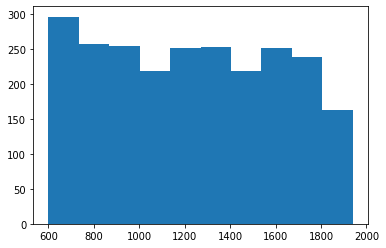

In [86]:
# change wait time definition.
import matplotlib.pyplot as plt
%matplotlib inline
queue_times = []
wait_times = []
stack = []

def add_tasks():
    for index, row in applications.iterrows():
        stack.insert(0,(index + 1, row)) 
        queue_times.append(0) # can do queue_times = [0] * 2400 outside loop
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(stack) == 0:
            time.sleep(1)
        else:
            task_number, application = stack.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            # each application takes 20 seconds to process.
            # an application is only processed after processeding applications were processed
            wait_times.append(queue_times[task_number - 1] * 20 + 600)
            for i in range(len(queue_times)):
                queue_times[i] += 1

t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / 2400
print(f'average_wait_time is {average_wait_time}')
plt.hist(wait_times)

In [303]:
# adding rows from applications to queue, first come first serve.
# process learlier added application first.
import threading
import math
import time

wait_times = []
queue = []

def add_tasks():
    for index, row in applications.iterrows():
        queue.append((index + 1, row))
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(queue) == 0:
            time.sleep(1)
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            wait_times.append((24 - math.ceil(task_number / 300)) * 3600)
                
t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / 2400
print(average_wait_time)

70200.0


In [304]:
class Queue():
    def __init__(self):
        self.items = []
    
    def push(self, value):
        self.items.append(value)
    
    def pop(self):
        return self.items.pop(0)
    
    def count(self):
        return len(self.items)

queue = Queue()
queue.push(1)
queue.push(2)
queue.push(3)
queue.pop()

1

1789.2083333333333


(array([  10.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,    6.,
        2342.]),
 array([ 600.,  722.,  844.,  966., 1088., 1210., 1332., 1454., 1576.,
        1698., 1820.]),
 <a list of 10 Patch objects>)

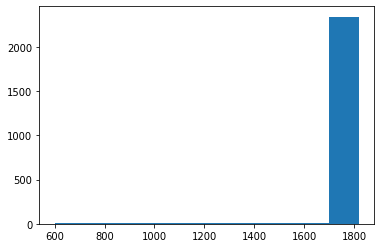

In [305]:
queue_times = []
wait_times = []
queue = []

def add_tasks():
    for index, row in applications.iterrows():
        queue.append((index + 1, row))
        queue_times.append(0)
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(queue) == 0:
            time.sleep(1)
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            wait_times.append(queue_times[task_number - 1] * 20 + 600)
            for i in range(len(queue_times)):
                queue_times[i] += 1

t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / 2400
print(average_wait_time)

plt.hist(wait_times)

The average wait time using a queue wasn't extremely different from the average wait time when using a stack. However, the histogram of the queue times did look very different.  Queues have a much lower maximum wait time than stacks used in the same scenario. 

    Queues are generally best when need to process all tasks at about the same pace.  Have a fairly low maximum wait time for processing tasks

    Stacks are generally best when tasks are need to be processed very quickly if possible, but are okay waiting around for a while if not.  Have a fairly high maximum wait time.


2


<BarContainer object of 2400 artists>

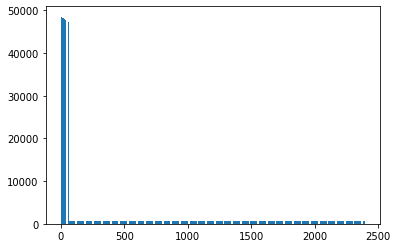

In [21]:
# checking waiting time by position in the list of tasks in a stack
queue_times = []
wait_times = [0] * 2400
stack = []

def add_tasks():
    for index, row in applications.iterrows():
        stack.insert(0,(index + 1, row))
        queue_times.append(0)
        time.sleep(.001)
        
def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(stack) == 0:
            time.sleep(1)
        else:
            task_number, application = stack.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            # Assign the wait time to the index corresponding to (task_number-1) in wait_times
            task_index = task_number - 1
            wait_times[task_index] = (queue_times[task_index] * 20 + 600)
            for i in range(len(queue_times)):
                queue_times[i] += 1

t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()
plt.bar(range(2400), wait_times)

In [38]:
ls = [(1,2),(3,4),(5,6)]
i,v = ls.pop(0)
print(i,v)

1 2


<BarContainer object of 2400 artists>

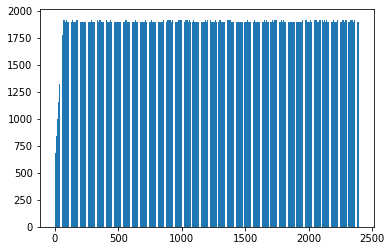

In [39]:
# checking waiting time by position in the list of tasks in a queue
queue_times = []
wait_times = [0] * 2400
queue = []

def add_tasks():
    for index, row in applications.iterrows():
        queue.append((index + 1, row))
        queue_times.append(0)
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(queue) == 0:
            time.sleep(1)
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            task_index = task_number - 1
            wait_times[task_index] = (queue_times[task_index] * 20 + 600)
            for i in range(len(queue_times)):
                queue_times[i] += 1

t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()
plt.bar(range(2400), wait_times)

    Stacks are better for tasks where immediacy matters, but if older messages are delivered slowly, it doesn't matter. One example is a social network like Twitter.
    Queues are better for tasks where consistency matters. An example is ordering delivery with a tool like Seamless. Seamless can't just ignore older orders, so they need to process everything with a queue to ensure fairness.

### Effectively Using Arrays And Lists
https://app.dataquest.io/m/173/effectively-using-arrays-and-lists

In [91]:
numbers = list(range(100))
binary = [bin(x).replace('ob', '') for x in numbers]
new_numbers = [int(x, 2) for x in binary]
new_numbers == numbers

True

In [92]:
numbers = list(range(100))
binary = [bin(num)[2:] for num in numbers]
new_numbers = [int(b, 2) for b in binary]
new_numbers == numbers

True

<BarContainer object of 20 artists>

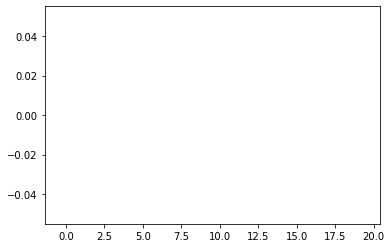

In [3]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

times = {}
iterations = 1000
numbers = list(range(20))
for i in range(iterations):
    l = []
    for i in numbers:
        start = time.time()
        l.append(i)
        elapsed = time.time() - start
        if i not in times:
            times[i] = []
        times[i].append(elapsed)

avg_times = []
for i in numbers:
    avg_times.append(sum(times[i]))

plt.bar(numbers, avg_times)

In [4]:
print(avg_times)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
sentence = "I desperately want a 1982 Winnebago."
sentence2 = sentence

values = [1,2,3,4,5]
sentence_hex = hex(id(sentence))
sentence2_hex = hex(id(sentence2))

values_elements_hex = [hex(id(elem)) for elem in values]
values_hex = hex(id(values))

print(sentence_hex)
print(sentence2_hex)
print(values_elements_hex)
print(values_hex)

0x1a5872e5608
0x1a5872e5608
['0x7ffe7c249340', '0x7ffe7c249360', '0x7ffe7c249380', '0x7ffe7c2493a0', '0x7ffe7c2493c0']
0x1a587214148


In [74]:
import numpy as np
with open("Raw_data\prices.csv", 'r') as f:
    data = f.readlines()

all_prices = [d.split(",")[1] for d in data][1:]
all_prices = [float(p.strip()) for p in all_prices]

In [20]:
np.zeros(5, dtype=np.float64)

array([0., 0., 0., 0., 0.])

In [40]:
class Array():
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.float64)
        self.size = size
    
    def __getitem__(self, key):
        return self.array[key]
    
    def __setitem__(self, key, value):
        self.array[key] = value
    
    def insert(self, position, value):
        new_array = np.zeros(self.size + 1, dtype=np.float64)
        new_pos = 0
        for i, item in enumerate(self.array):
            if i == position:
                new_array[new_pos] = value
                new_pos += 1
            new_array[new_pos] = item
            new_pos += 1
        if position == (self.size):
            new_array[new_pos] = value
        self.size += 1
        self.array = new_array
    
    def __len__(self):
        return self.size
    
    def append(self, value):
        self.insert(self.size, value)
        
    def pop(self, position):
        new_array = np.zeros(self.size-1, dtype=np.float64)
        new_position = 0
        for i, item in enumerate(self.array):
            if i == position:
                removed = item
                continue
            new_array[new_position] = self.array[i]
            new_position += 1
        self.array = new_array
        return removed
            
prices = Array(0)
for price in all_prices[:100]:
    prices.append(price)
prices.pop(40)

622.401069

In [33]:
all_prices[40]

622.401069

In [71]:
prices = Array(10)

for i in range(10):
    prices[i] = all_prices[i]
print(list(prices))

[665.411118, 668.281154, 659.011109, 650.021102, 622.461047, 623.141078, 625.961061, 629.641069, 624.991068, 628.581079]


In [72]:
prices = Array(0)
print(list(prices))

for price in all_prices[:100]:
    prices.append(price)

prices.insert(50, 646.921081)

[]


In [81]:
class Node():
    def __init__(self, value):
        self.value = value
        self.next_node = None
    
    def set_next_node(self, node):
        self.next_node = node
    
    def append(self, value):
        next_node = Node(value)
        self.next_node = next_node
        return next_node
    
    def __getitem__(self, key):
        node = self
        counter = 0
        while counter < key:
            node = node.next_node
            counter += 1
        return node

    def insert(self, position, value):
        if position == 0:
            node = Node(value)
            node.next_node = self
            return node
        else:
            node = Node(value)
            split_start = self[position - 1]
            split_end = split_start.next_node
            split_start.next_node = node
            node.next_node = split_end
            return self

    def pop(self, position):
        if position == 0:
            return self, self.next_node
        else:
            split_start = self[position - 1]
            to_remove = split_start.next_node
            split_end = to_remove.next_node
            split_start.next_node = split_end
            return to_remove, self
        

In [82]:
price_1 = Node(all_prices[0])
node = price_1
for i in all_prices[1:5]:
    node = node.append(i)

current_node = price_1
while current_node.next_node is not None:
    print(current_node.value)
    current_node = current_node.next_node
print(current_node.value)

665.411118
668.281154
659.011109
650.021102
622.461047


In [83]:
price_1 = Node(all_prices[0])
node = price_1
for i in all_prices[1:5]:
    node = node.append(i)
# print the value of the 3rd element
print(price_1[2].value)

659.011109


In [84]:
price_1 = Node(all_prices[0])
node = price_1
# append the next 4 prices from all_prices to the linked list
for i in all_prices[1:5]:
    node = node.append(i)

# Insert the element with index 5 in all_prices into position 3 of the linked list.
price_1 = price_1.insert(3, all_prices[5])
# Insert the element with index 6 in all_prices into position 0 of the linked list.
price_1 = price_1.insert(0, all_prices[6])
# Insert the element with index 7 in all_prices into position 7 of the linked list
price_1 = price_1.insert(7, all_prices[7])

print(price_1[4].value)
        

623.141078


In [86]:
price_1 = Node(all_prices[0])
node = price_1
for i in all_prices[1:5]:
    node = node.append(i)

removed, price_1 = price_1.pop(0)
removed, price_1 = price_1.pop(3)

print(price_1[2].value)

650.021102


### Sorting Arrays And Lists
https://app.dataquest.io/m/174/sorting-arrays-and-lists

In [4]:
import pandas as pd
df = pd.read_csv('amounts.csv')
amounts = df['Amount'].tolist()
times = df['Time'].tolist()

In [12]:
def swap(array, pos1, pos2):
    temp = array[pos1]
    array[pos1] = array[pos2]
    array[pos2] = temp
first_amounts = amounts[:10]
print(first_amounts)
swap(first_amounts, 0, 1)
print(first_amounts)

[149.62, 2.69, 378.66, 123.5, 69.99, 3.67, 4.99, 40.8, 93.2, 3.68]
[2.69, 149.62, 378.66, 123.5, 69.99, 3.67, 4.99, 40.8, 93.2, 3.68]


In [14]:
def selection_sort(array):
    pass
def selection_sort(array):
    for i in range(len(array)):
        lowest_index = i
        for z in range(i, len(array)):
            if array[z] < array[lowest_index]:
                lowest_index = z
        swap(array, lowest_index, i)

first_amounts = amounts[:10]
selection_sort(first_amounts)
print(first_amounts)

[2.69, 3.67, 3.68, 4.99, 40.8, 69.99, 93.2, 123.5, 149.62, 378.66]


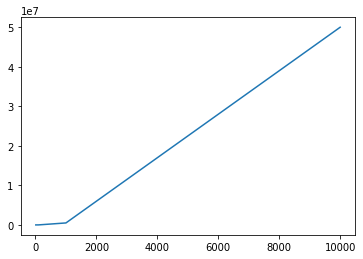

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def selection_sort(array):
    counter = 0
    for i in range(len(array)):
        lowest_index = i
        for z in range(i, len(array)):
            counter += 1
            if array[z] < array[lowest_index]:
                lowest_index = z
        swap(array, lowest_index, i)
    return counter

lengths = [10,100,1000,10000]
counters = []
for i in lengths:
    first_amounts = amounts[:i]
    counter = selection_sort(first_amounts)
    counters.append(counter)

plt.plot(lengths, counters)

In [20]:
def bubble_sort(array):
    swaps = 1
    while swaps > 0:
        swaps = 0
        for i in range(len(array) - 1):
            if array[i] > array[i+1]:
                swap(array, i, i+1)
                swaps += 1

first_amounts = amounts[:10]
bubble_sort(first_amounts)
print(amounts[:10])
print(first_amounts)

[149.62, 2.69, 378.66, 123.5, 69.99, 3.67, 4.99, 40.8, 93.2, 3.68]
[2.69, 3.67, 3.68, 4.99, 40.8, 69.99, 93.2, 123.5, 149.62, 378.66]


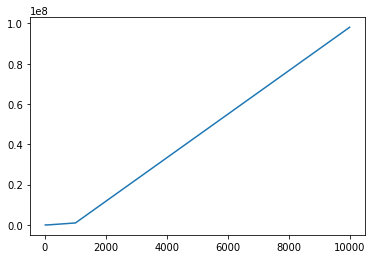

In [21]:
# profile the bubble sort 
import matplotlib.pyplot as plt

def bubble_sort(array):
    counter = 0
    swaps = 1
    while swaps > 0:
        swaps = 0
        for i in range(len(array) - 1):
            counter += 1
            if array[i] > array[i+1]:
                swap(array, i, i+1)
                swaps += 1
    return counter

counters = []
lengths = [10,100,1000,10000]
for l in lengths:
    first_amounts = amounts[:l]
    counter = bubble_sort(first_amounts)
    counters.append(counter)
plt.plot(lengths, counters)

In [23]:
# The insertion sort works by looping through each element in the array, and "inserting" it into a sorted list 
# at the beginning of the array.
def insertion_sort(array):
    for i in range(1, len(array)):
        j = i
        while j > 0 and array[j - 1] > array[j]:
            swap(array, j, j-1)
            j-=1

first_amounts = amounts[:10]
insertion_sort(first_amounts)
print(amounts[:10])
print(first_amounts)

[149.62, 2.69, 378.66, 123.5, 69.99, 3.67, 4.99, 40.8, 93.2, 3.68]
[2.69, 3.67, 3.68, 4.99, 40.8, 69.99, 93.2, 123.5, 149.62, 378.66]


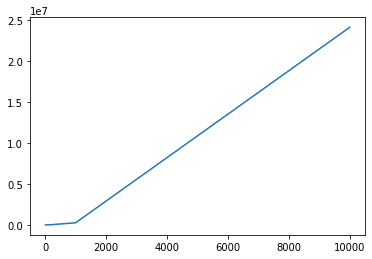

In [27]:
# profile insertion_sort
import matplotlib.pyplot as plt

def insertion_sort(array):
    counter = 0
    for i in range(1, len(array)):
        j = i
        while j > 0 and array[j - 1] > array[j]:
            swap(array, j, j-1)
            counter +=1
            j-=1
    return counter
counters = []
lengths = [10,100,1000,10000]
for l in lengths:
    first_amounts = amounts[:l]
    counter = insertion_sort(first_amounts)
    counters.append(counter)
plt.plot(lengths, counters)

### Searching Arrays And Lists
https://app.dataquest.io/m/175/searching-arrays-and-lists

In [30]:
import pandas as pd

data = pd.read_csv("amounts.csv")
amounts = list(data["Amount"])
times = [int(i) for i in list(data["Time"])]
first_4554 = times.index(4554)
print(first_4554)

4988


In [33]:
def linear_search(array, search):
    indexes = []
    for idx, item in enumerate(array):
        if item == search:
            indexes.append(idx)
    return indexes
sevens = linear_search(times, 7)
print(sevens)

[7, 8]


In [39]:
def linear_multi_search(array, search):
    indexes = []
    for idx, item in enumerate(array):
        if item == search:
            indexes.append(idx)
    return indexes
transactions = zip(times, amounts)
results = linear_multi_search(transactions, (56, 10.84))
print(results)

[88]


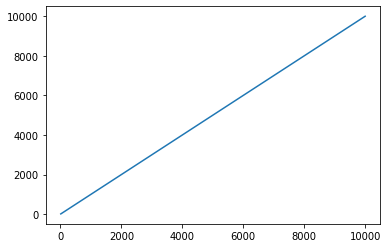

In [42]:
import matplotlib.pyplot as plt

def linear_search(array, search):
    counter = 0
    indexes = []
    for i, item in enumerate(array):
        counter += 1
        if item == search:
            indexes.append(i)
    return counter

counters = []
lengths = [10,100,1000,10000]
for i in lengths:
    first_amounts = amounts[:i]
    counter = linear_search(first_amounts, 7)
    counters.append(counter)
plt.plot(lengths, counters) # linear search takes O(n) time in the worst case

In [58]:
import math

def swap(array, pos1, pos2):
    store = array[pos1]
    array[pos1] = array[pos2]
    array[pos2] = store

def insertion_sort(array):
    for i in range(1, len(array)):
        j = i
        while j > 0 and array[j - 1] > array[j]:
            swap(array, j, j-1)
            j-=1

def binary_search(array, search):
    insertion_sort(array)
    m = 0
    i = 0
    z = len(array) - 1.
    while i <= z:
        m = math.floor(i + ((z - i) / 2))
        if array[m] == search:
            return m
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m-1
result = binary_search(times, 56)
print(result)

87


In [61]:
def binary_search(array, search):
    array.sort()
    m = 0
    i = 0
    z = len(array) - 1
    while i<= z:
        m = math.floor(i + ((z - i) / 2))
        if array[m] == search:
            return m
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m - 1
transactions = ["{}_{}".format(times[i], amounts[i]) for i in range(len(amounts))]
result = binary_search(transactions, "56_10.84")
print(result)

205929


In [102]:
def binary_search(array, search):
    array.sort()
    m = 0
    i = 0
    z = len(array) - 1
    while i<= z:
        m = math.floor(i + ((z - i) / 2))
        if array[m] == search:
            return m
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m - 1
    return m

# look at the range of values "around" the m position
def fuzzy_match(array, lower, upper, m):
    j = m
    l = m + 1
    matches = []
    while j > 0 and lower <= array[j] <= upper:
        matches.append(array[j])
        j -= 1
        
    while l < len(array) and lower <= array[l] <= upper:
        matches.append(array[l])
        l += 1
    return matches

m = binary_search(amounts, 150)
matches = fuzzy_match(amounts, 149.98, 150, m)
print(matches)

[150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0

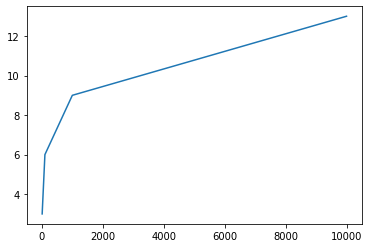

In [110]:
import matplotlib.pyplot as plt

def binary_search(array, search):
    counter=0
    array.sort()
    m = 0
    i = 0
    z = len(array) - 1
    while i<= z:
        counter += 1
        m = math.floor(i + ((z - i) / 2))
        if array[m] == search:
            return m
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m - 1
    return counter
lengths = [10,100,1000,10000]
counters =[]
for length in lengths:
    first_amounts = amounts[:length]
    c = binary_search(first_amounts, -1)
    counters.append(c)
    
plt.plot(lengths, counters)

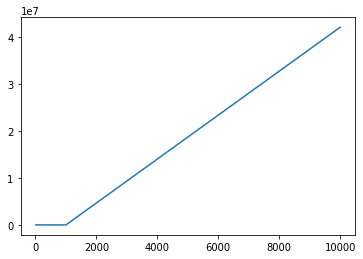

In [112]:
def insertion_sort(array):
    counter = 0
    for i in range(1, len(array)):
        j = i
        while j > 0 and array[j - 1] > array[j]:
            counter += 1
            swap(array, j, j-1)
            j-=1
    return counter

def binary_search(array, search):
    counter = insertion_sort(array)
    insertion_sort(array)
    m = 0
    i = 0
    z = len(array) - 1
    while i<= z:
        counter += 1
        m = math.floor(i + ((z - i) / 2))
        if array[m] == search:
            return m
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m - 1
    return counter

lengths = [10,100,1000,10000]

counters = []
for i in lengths:
     # We sort in reverse order so we get the worst case performance of the insertion sort.
    first_amounts = sorted(amounts[:i], reverse=True)
    counter = binary_search(first_amounts, -1)
    counters.append(counter)
plt.plot(lengths, counters)

### Hash Tables
https://app.dataquest.io/m/176/hash-tables

"os.path.join(dir_name, base_filename + "." + filename_suffix)" joins path with the filename and extension.  It smooths over that OS difference so cross-platform code doesn't have to be cluttered with special cases for each OS.
There is no need to do this for file name "extensions" because they are always connected to the rest of the name with a dot character, on every OS.

In [ ]:
import os
quotes = {}
directory = "lines"
for filename in os.listdir(directory):
    with open(os.path.join(directory, filename)) as f:
        quotes[filename.replace(".txt", "")] = f.read() # Read the data in the file into a string variable

In [ ]:
# A hash function maps a key to a position in an array.  It will always return the same output with the same input
def simple_hash(key):
    key = str(key)
    return ord(key[0]) # ord() function returns an integer character code corresponding to a unicode character

xmen_hash = simple_hash('xman')
things_hash = simple_hash('10thingsihateaboutyou') # returned 49

In [ ]:
# Using a modulo operator on the value returned by hash function ensures that the index returned is never larger 
# than the size of the array. Simply use the size of array as the divisor.
def simple_hash(key):
    key = str(key)
    code = ord(key[0])
    return code % 20

xmen_hash = simple_hash("xmen")
things_hash = simple_hash("10thingsihateaboutyou") # returned 9

In [ ]:
import numpy as np

class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = simple_hash(key)
        return self.array[ind]
    
    def __setitem__(self, key, value):
        ind = simple_hash(key)
        self.array[ind] = value

hash_table = HashTable(20)

with open("lines/xmen.txt", 'r') as f:
    hash_table["xmen"] = f.read()

In [ ]:
# deal with hash collisions by allowin each position in the array to store multiple values
# The isinstance() function checks if the object is an instance or subclass of classinfo class.
# isinstance(object, classinfo)
# If the value in the array at position isn't a list
    if not isinstance(self.array[ind], list)

In [ ]:
class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = simple_hash(key)
        return self.array[ind]
    
    def __setitem__(self, key, value):
        ind = simple_hash(key)
        # store a list of values at each array position to avoid collisions
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        self.array[ind].append(value)

hash_table = HashTable(20)

with open("lines/xmen.txt", 'r') as f:
    hash_table["xmen"] = f.read()

with open("lines/xmenoriginswolverine.txt", 'r') as f:
    hash_table["xmenoriginswolverine"] = f.read()

In [7]:
ls = [1,2,3]
isinstance(ls, list)

True

In [ ]:
class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = simple_hash(key)
        for k,v in self.array[ind]:
            if key == k:
                return v
    
    def __setitem__(self, key, value):
        ind = simple_hash(key)
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        # store both the key and the value for easy search
        self.array[ind].append((key,value))
        
hash_table = HashTable(20)

with open("lines/xmen.txt", 'r') as f:
    hash_table["xmen"] = f.read()

with open("lines/xmenoriginswolverine.txt", 'r') as f:
    hash_table["xmenoriginswolverine"] = f.read()

Retrival issues.  
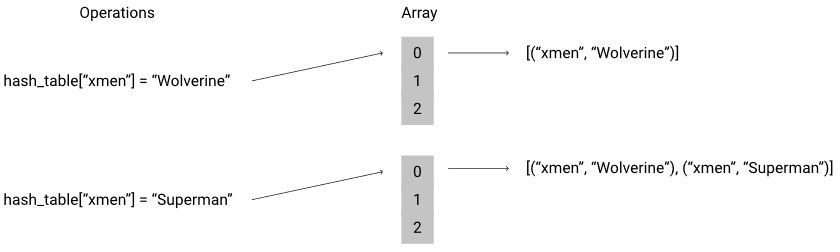

1. Iterate from the back of the list at the array position to the front in __getitem__ to get the latest value associated with a key instead of the earliest.  Consumes more memory, and causes slower indexing.
2. In __setitem__, iterate through the list at the array position, and replace the current value with a new one. slower insertion faster indexing.
3. Since dictionaries are usually indexed more than inserted into, it usually makes more sense to use the second method.

In [ ]:
class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = simple_hash(key)
        for k,v in self.array[ind]:
            if key == k:
                return v
    
    def __setitem__(self, key, value):
        ind = simple_hash(key)
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        replace = None
        for i,data in enumerate(self.array[ind]):
            # If the first item in the tuple matches key, store the position in replace.
            if data[0] == key:
                replace = i
        # If replace is None, append a tuple containing the key and the value to the list.
        if replace is None:
            self.array[ind].append((key,value))
        else:
            # If replace isn't None, replace the tuple at the position in the array with the new (key,value) tuple
            self.array[ind][replace] = (key, value)

hash_table = HashTable(20)

with open("lines/xmen.txt", 'r') as f:
    hash_table["xmen"] = f.read()

with open("lines/xmenoriginswolverine.txt", 'r') as f:
    hash_table["xmen"] = f.read()

The worst case time complexity is when all of the hash table keys and values are stored in a single array position.  Since a linear search has to be done to locate the value.  

In [ ]:
# Profiling a HashTable instance with only one available array position
class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        counter = 0
        ind = simple_hash(key)
        for k,v in self.array[ind]:
            counter += 1
            if key == k:
                return counter
    
    def __setitem__(self, key, value):
        ind = simple_hash(key)
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        replace = None
        for i,data in enumerate(self.array[ind]):
            if data[0] == key:
                replace = i
        if replace is None:
            self.array[ind].append((key,value))
        else:
            self.array[ind][replace] = (key, value)

data = [
    ("xmen", "Wolverine"), 
    ("xmenoriginswolverine", "Superman"), 
    ("vanillasky", "Thor"), 
    ("tremors", "Aquaman")
]
hash_table = HashTable(1)
for k,v in data:
    hash_table[k] = v

counter = hash_table[k] # output 4

In [ ]:
data = [
    ("xmen", "Wolverine"), 
    ("xmenoriginswolverine", "Superman"), 
    ("vanillasky", "Thor"), 
    ("tremors", "Aquaman"),
    ("a", "b"), 
    ("c", "d")
]
hash_table = HashTable(1)
for k,v in data:
    hash_table[k] = v

counter = hash_table[k] # output 6

The built-in Python hash() function is used by Python's built-in hash table implementation, dict. This algorithm will hashing based on the entire string, not just the first character, allowing the use of longer arrays, which makes hash collisions less likely, thus increasing speed for insertion and lookups.

In [ ]:
# improvig the time complexity by increasing the size of the array, and the hashing algorithm.
import time
import os
import matplotlib.pyplot as plt

class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = hash(key) % self.size
        for k,v in self.array[ind]:
            if key == k:
                return v
    
    def __setitem__(self, key, value):
        ind = hash(key) % self.size
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        replace = None
        for i,data in enumerate(self.array[ind]):
            if data[0] == key:
                replace = i
        if replace is None:
            self.array[ind].append((key,value))
        else:
            self.array[ind][replace] = (key, value)

def profile_table(size):
    start = time.time()
    hash_table = HashTable(size)
    directory = "lines"
    
    for filename in os.listdir(directory):
        name = filename.replace(".txt", "")
        hash_table[name] = quotes[name]
    duration = time.time() - start
    return duration

times = []
lengths = [1,10,20,30,40,50]
for length in lengths:
    s = profile_table(length)
    times.append(s)
    
plt.plot(lengths, times)